In [1]:
# https://www.cvxpy.org/examples/applications/robust_kalman.html?highlight=solvers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle as pkl
from datetime import datetime
# from varname import nameof
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def lorenz(x, y, z, sigma=10, rho=28, beta=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = sigma*(y - x)
    y_dot = rho*x - y - x*z
    z_dot = x*y - beta*z
    return x_dot, y_dot, z_dot

In [4]:
def simLorenz(sigma=10,rho=28,beta=2.667,dt=0.001,h=0.05,L=6000):

    hnum = int(h/dt)  # Number of integrations per observation

    obsX = np.empty(L)
    obsY = np.empty(L)
    obsZ = np.empty(L)
    obsT = np.empty(L)

    obsX[0],obsY[0],obsZ[0],obsT[0] = (0.,1.,1.05,0.)

    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(L-1):
        x0 = obsX[i]
        y0 = obsY[i]
        z0 = obsZ[i]

        for hcnt in range(hnum):
            x_dot, y_dot, z_dot = lorenz(x0, y0, z0, sigma = sigma, rho = rho, beta = beta)
            x0 += x_dot*dt
            y0 += y_dot*dt
            z0 += z_dot*dt

        obsX[i+1] = x0
        obsY[i+1] = y0
        obsZ[i+1] = z0
        obsT[i+1] = obsT[i]+h

    return obsT,obsX,obsY,obsZ

In [5]:
def Takens(memData,obsData,numTVect):
    lenObs = len(obsData)
    norms = dict((i, np.linalg.norm([a - b for a,b in zip(obsData,memData[i:i+lenObs])])) for i in range(len(memData)-lenObs))
    libTakens = dict((k,v) for k,v in sorted(norms.items(), key=lambda item: item[1])[:kmax])
    estTakens = np.sum([memData[k+lenObs] for k,v in libTakens.items()])/float(numTVect)
    return estTakens,libTakens

In [6]:
def libPrint(memData,memOffset,obsData,obsPred,obsActl,libTakens,dataPrint=True):

    lenObs = len(obsData)
    print(' '*13,end='')
    if dataPrint:
        print(' ',' '.join(['{0:7.3f}'.format(v) for v in obsData]),end='')
    print(' '*3,'{0:7.3f}'.format(obsActl))
    runSum = 0.0
    for ndx,(row,dlt) in enumerate(sorted(libTakens.items(),key=lambda item: item[1])):
        rowStart = row
        runSum += memData[rowStart+lenObs]
        runPrd = runSum/float(ndx+1.0)
        print(' '*3,'{0:2d} {1:6d}: '.format(ndx,rowStart + memOffset),end='')                          # Closest Takens Vector Number (1-KMax), Starting index
        if dataPrint:
            print(' '.join(['{0:7.3f}'.format(v) for v in memData[rowStart:rowStart+lenObs]]),end='  ') # d-long Takens vector, observation
        print('  {0:7.3f}'.format(memData[rowStart+lenObs]),end='  ')                                   # Next obs for given Takens vector (compare with )True next sample)
        # print('{0:7.3f}'.format( np.linalg.norm([a_i - b_i for a_i, b_i in zip(obsData,memData[rowStart:rowStart+lenObs])]) ),end='  ') # Norm of preceeding observation and this Takens vector
        print('{0:7.3f}'.format( dlt ),end='  ') # Norm of preceeding observation and this Takens vector
        print('  {0:7.3f}  {1:8.2e}'.format(runPrd,np.abs(runPrd-obsActl)))
    return

In [7]:
# Define the simulation parameters

dt = 0.001   # Integration time step for the dynamical system
h = 0.05     # Observation rate
lenSim = 2**13 # Length of simulation data

In [8]:
# Define the MRA.

JMax = 5     # Number of scales in the MRA (<= log2(lenSim))


In [9]:
# Define the wavelet filter coefficients

denom = 4.0*np.sqrt(2.0)
sqrt2 = np.sqrt(2.0)
sqrt3 = np.sqrt(3.0)

lpCoeffs = {}
lpCoeffs['daubL1'] = [ 1.0/sqrt2,1.0/sqrt2]  # aka Haar
lpCoeffs['daubL2'] = [(1.0-sqrt3)/denom, (3.0-sqrt3)/denom, (3.0+sqrt3)/denom, (1.0+sqrt3)/denom]
lpCoeffs['daubL3'] = [0.035226291882100656,-0.08544127388224149,
          -0.13501102001039084,0.4598775021193313,
          0.8068915093133388,0.3326705529509569]
lpCoeffs['coifL6'] = [-3.459977283621256e-05,-7.098330313814125e-05,0.0004662169601128863,0.0011175187708906016,-0.0025745176887502236,-0.00900797613666158,
        0.015880544863615904,0.03455502757306163,-0.08230192710688598,-0.07179982161931202,0.42848347637761874,0.7937772226256206,
        0.4051769024096169,-0.06112339000267287,-0.0657719112818555,0.023452696141836267,0.007782596427325418,-0.003793512864491014]

filtName = 'daubL2'

filtLP = lpCoeffs[filtName]
filtHP = [(-1.0)**(k+1)*v for k,v in enumerate(filtLP[::-1])]

L = len(filtLP)

print('Filter Name:  ',filtName)
print('Low Pass:  ',' '.join(['{0:12.8f}'.format(v) for v in filtLP]))
print('High Pass: ',' '.join(['{0:12.8f}'.format(v) for v in filtHP]))

Filter Name:   daubL2
Low Pass:    -0.12940952   0.22414387   0.83651630   0.48296291
High Pass:   -0.48296291   0.83651630  -0.22414387  -0.12940952


In [23]:
# Create synthetic data

dims = ['x','y','z']

obsSig = {}

obsNyz = np.zeros((len(dims),lenSim))
noizName = 'clean'
if 0:  # Generate Noise signal
    noizName = 'noisy'
    mu, sigma = 0, 0.025
    obsNyz = np.random.normal(mu,sigma,(len(dims),lenSim))

if 0:  # Generate Lorenz Data + noise (if appropriate)
    baseFileName = 'DecompLorenz_' + filtName + '_' + noizName + '_'
    sigmas = [   10]   #  [    8,     9,    10,    11,    12] # [   10]
    rhos   = [   28]   #  [   26,    27,    28,    29,    30] # [   28]
    betas  = [2.667]   #  [2.667, 2.667, 2.667, 2.667, 2.667] # [2.667]
    numChannels = len(sigmas)
    obsT = np.empty([numChannels,lenSim])
    obsX = np.empty([numChannels,lenSim])
    obsY = np.empty([numChannels,lenSim])
    obsZ = np.empty([numChannels,lenSim])
    for i in range(numChannels):
        sigma = sigmas[i]
        rho   = rhos[i]
        beta  = betas[i]
        obsT[i,:],obsX[i,:],obsY[i,:],obsZ[i,:] = simLorenz(sigma=sigma,rho=rho,beta=beta,dt=dt,h=h,L=lenSim)
    
    channel = 0
    t = obsT[channel,:]
    obsSig['x'] = obsX[channel,:] + obsNyz[0]
    obsSig['y'] = obsY[channel,:] + obsNyz[1]
    obsSig['z'] = obsZ[channel,:] + obsNyz[2]

if 1:  # Generate Sine wave + noise (if appropriate)
    baseFileName = 'DecompSine_' + filtName + '_' + noizName + '_'
    t = np.arange(0, 10, (10.0-0.0)/float(lenSim))
    omegaVals = [0.5, 0.75, 1.25]
    for idim,dim in enumerate(dims):
        obsSig[dim] = np.sin(2.0*np.pi*omegaVals[idim]*t+2*t)  + obsNyz[idim,:]
    

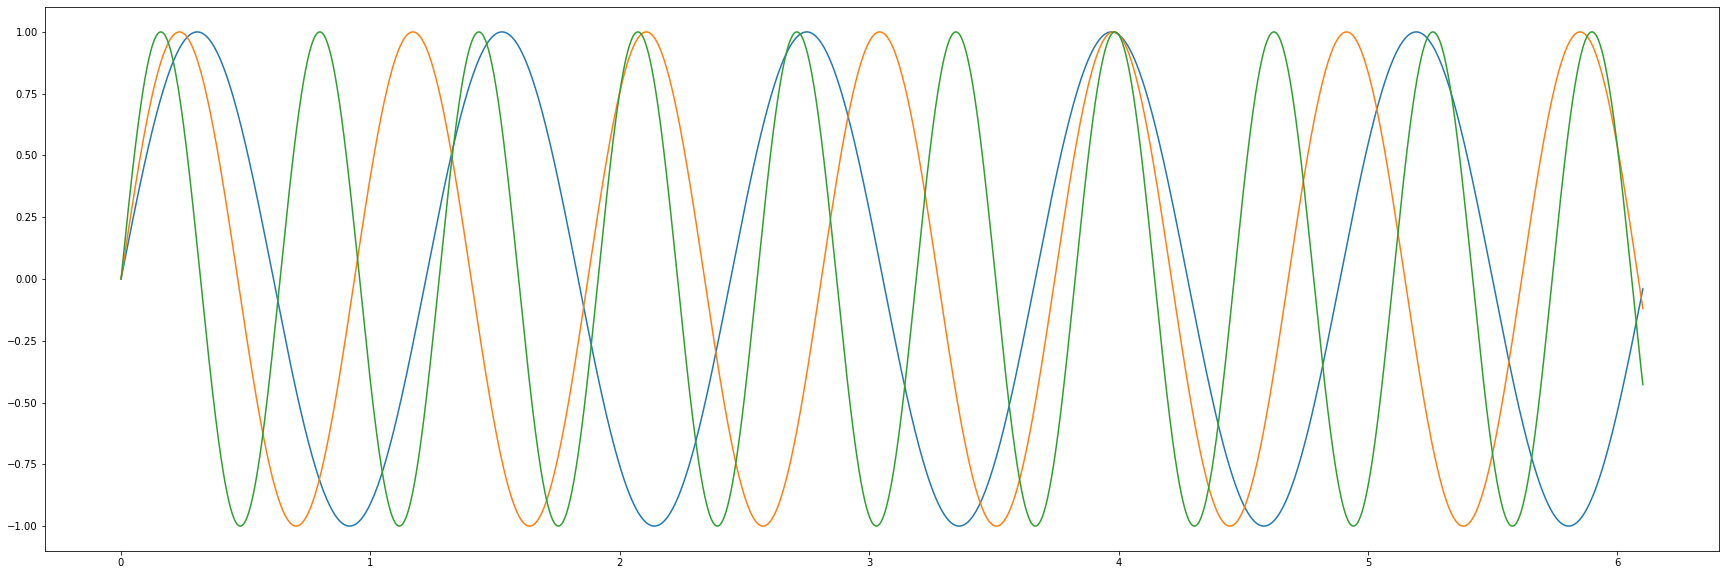

In [27]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
for dim in dims:
    plt.plot(t[:5000],obsSig[dim][:5000])
plt.show()

# Plot synthetic data

if 0:
    fig,ax = plt.subplots(1,1,figsize=(30,10))
    plt.plot(t[:1000],obsSig[:1000])
    plt.show()

if 0: # This is specific for Lorenz
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    ax.plot(obsX[channel,:], obsY[channel,:], obsZ[channel,:], lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")
    plt.show()

In [25]:
# Project all the data in a "streamy" fashion.

start_time = time.time()
prev_time = start_time

repStep =  int(lenSim/32)

projV = {}
projW = {}
for dim in dims:
    projV[dim] = {}
    projW[dim] = {}
    for j in range(JMax+1):
        projV[dim][j] = []
        projW[dim][j] = []

for i in range(lenSim): # For each simulated data point.
    if i%repStep == 0:
        curr_time = time.time()
        print('{0:7d} {1:3d} {2:3d}  {3:7.3f}  {4:7.3f}'.format(i,int(i/repStep),int(lenSim/repStep),curr_time-prev_time,curr_time-start_time))
        prev_time = curr_time
    for dim in dims:
        s0 = obsSig[dim][i]  # "Generate" a sample
        j = 0
        projV[dim][j].append(s0)
        for j in range(1,JMax+1):
            if (len(projV[dim][j-1]) >= L) and (len(projV[dim][j-1])%2 == 0):
                sjk = np.dot(filtLP[::-1],projV[dim][j-1][-L:])
                djk = np.dot(filtHP[::-1],projV[dim][j-1][-L:])
                projV[dim][j].append(sjk)
                projW[dim][j].append(djk)
                # This is where a "streaming Takens" step occurs.
            else:
                break
#
end_time = time.time()
print('Total:  ',end_time-start_time)

      0   0  32    0.001    0.001
    256   1  32    0.008    0.010
    512   2  32    0.007    0.017
    768   3  32    0.009    0.025
   1024   4  32    0.010    0.035
   1280   5  32    0.007    0.042
   1536   6  32    0.009    0.051
   1792   7  32    0.008    0.059
   2048   8  32    0.008    0.067
   2304   9  32    0.008    0.075
   2560  10  32    0.008    0.083
   2816  11  32    0.008    0.091
   3072  12  32    0.008    0.099
   3328  13  32    0.008    0.107
   3584  14  32    0.008    0.115
   3840  15  32    0.008    0.123
   4096  16  32    0.008    0.131
   4352  17  32    0.008    0.139
   4608  18  32    0.008    0.148
   4864  19  32    0.008    0.156
   5120  20  32    0.008    0.164
   5376  21  32    0.008    0.172
   5632  22  32    0.009    0.181
   5888  23  32    0.008    0.189
   6144  24  32    0.008    0.197
   6400  25  32    0.008    0.205
   6656  26  32    0.008    0.213
   6912  27  32    0.008    0.221
   7168  28  32    0.008    0.229
   7424  29  3

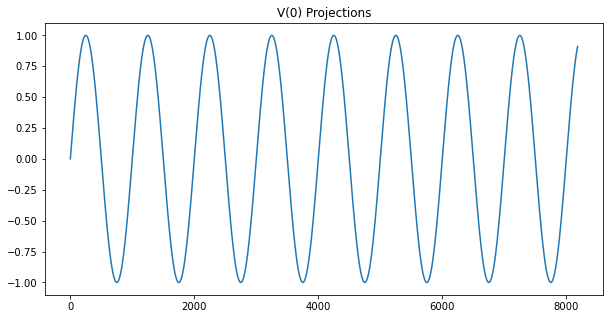

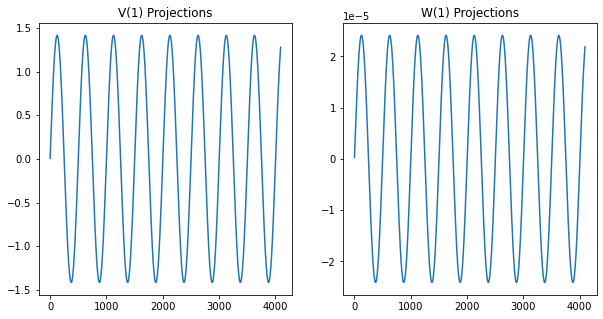

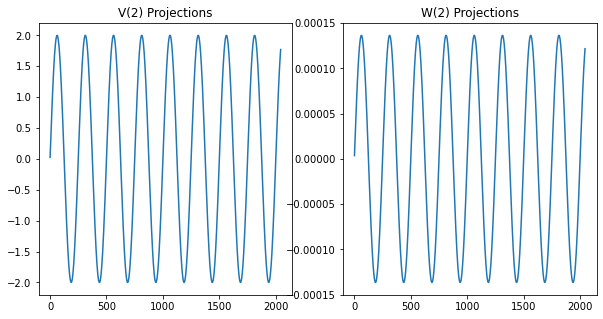

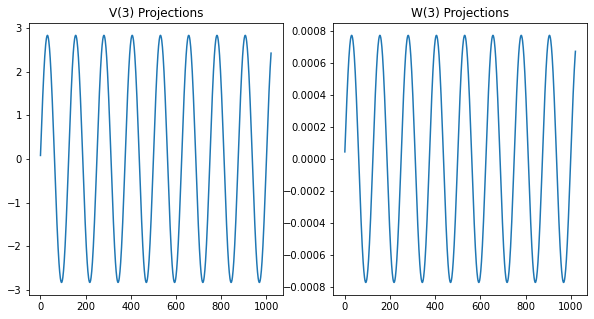

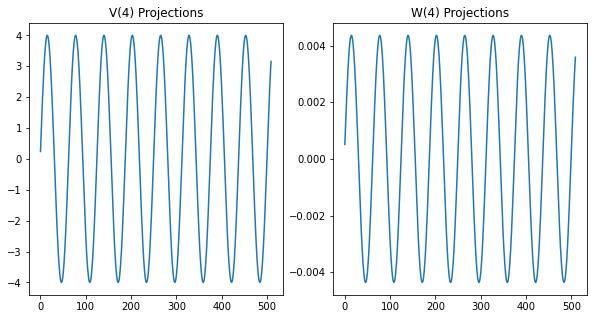

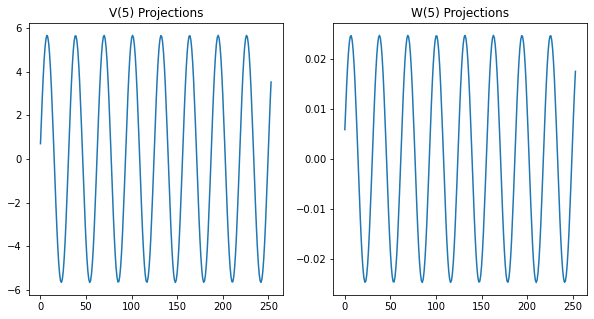

In [28]:
# For each dimension, plot all the projections.
for dim in dims:
    for j in range(JMax+1):
        if j > 0:
            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(1, 2, 1)
        else:
            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(1, 1, 1)
        tlen = np.arange(len(projV[dim][j]))
        ax.plot(tlen,projV[dim][j])
        ax.set_title("V({0:d}) Projections".format(j))
        if j > 0:
            ax = fig.add_subplot(1, 2, 2)
            ax.plot(tlen,projW[dim][j])
            ax.set_title("W({0:d}) Projections".format(j))
        plt.show()
    break

In [29]:
# Scale-dependent Takens parameters

memLen = {}  # Length of memory used to derive Takens vectors
Td = {}      # Length of Takens vector: [x(t), x(t+h), x(t+2h)...x(t+(d-1)h)].  Next sample is x(t+dh) (observed or predicted)
KMax = {}    # Number of closest Takens observations to keep
for j in range(0,JMax+1):
    memLen[j] = lenSim//(2**(j+4))
    Td[j] = 10
    KMax[j] = 20
bufMul = 5  # Buffer length multiplier:  Td[j]*bufMul = number of samples separating current observation from memory data.

for j in range(JMax+1):
    if len(projV[dims[0]][j]) < memLen[j] + bufMul*(Td[j] + 1) + 1: # MRA length needs to "support" Takens memory, buffer and observation.
        break
    print('{0:2d} {1:6d} {2:6d} {3:2d} {4:2d}'.format(j,len(projV[dims[0]][j]),memLen[j],Td[j],KMax[j]))

 0   8192    512 10 20
 1   4095    256 10 20
 2   2046    128 10 20
 3   1022     64 10 20
 4    510     32 10 20
 5    254     16 10 20


In [150]:
dim = dims[0]
j = 0

lenObs = Td[j]
kmax = KMax[j]

kmax = 5

lenScl = len(projV[dim][j])

mem0 = np.random.randint(0,lenScl//4)
mem1 = 3*lenScl//8 + np.random.randint(0,lenScl//8)
obs0 = 3*lenScl//4 + np.random.randint(0,lenScl//4-lenObs)
obs1 = obs0+lenObs

print(mem0,mem1,mem1-mem0,'\t',obs0,obs1,obs1-obs0)

1225 3853 2628 	 6608 6618 10


In [157]:
def vPrint(lab,dat,end):
    print(lab,' '.join(['{0:7.3f}'.format(v) for v in dat]),end=end)

'\n\ntest\n\n'

In [161]:
# prdV = {}
# libV = {}
# prdW = {}
# libW = {}
# for dim in dims:
#     mem = projV[dim][j][mem0:mem1]
#     obs = projV[dim][j][obs0:obs1]
#     prdV[dim],libV[dim] = Takens(memData=mem,obsData=obs,numTVect=kmax)

#     inpData = np.zeros((kmax+1,lenObs+1),dtype=float)
    
#     vPrint('   O: ',np.append(obs,projV[dim][j][obs1]),end='\n')
#     inpData[0,:-1] = obs
#     inpData[0,-1] = np.inf
#     for i,l in enumerate(libV[dim]):
#         print('{0:>2d}'.format(i),end=' ')
#         vPrint('L: ',mem[l:l+lenObs+1],' '*3)
#         print('{0:9.3e}'.format(np.linalg.norm(np.subtract(obs,mem[l:l+lenObs]))))
#         inpData[i+1,:] = mem[l:l+lenObs+1]

#     break

In [164]:
prdV = {}
libV = {}
prdW = {}
libW = {}
for dim in dims:
    mem = projV[dim][j][mem0:mem1]
    obs = projV[dim][j][obs0:obs1]
    prdV[dim],libV[dim] = Takens(memData=mem,obsData=obs,numTVect=kmax)

    inpData = []  # np.zeros((kmax+1,lenObs+1),dtype=float)
    
    vPrint('   O: ',np.append(obs,projV[dim][j][obs1]),end='\n')
#     inpData[0,:-1] = obs
#     inpData[0,-1] = np.inf
    
    for i,l in enumerate(libV[dim]):
        print('{0:>2d}'.format(i),end=' ')
        vPrint('L: ',mem[l:l+lenObs+1],' '*3)
        print('{0:9.3e}'.format(np.linalg.norm(np.subtract(obs,mem[l:l+lenObs]))))
#         inpData[i+1,:] = mem[l:l+lenObs+1]
        inpData.append([mem[l:l+lenObs],mem[lenObs]])

    break

   O:   -0.592  -0.597  -0.602  -0.607  -0.612  -0.617  -0.622  -0.627  -0.632  -0.637  -0.641
 0 L:   -0.593  -0.598  -0.603  -0.608  -0.613  -0.618  -0.623  -0.628  -0.633  -0.638  -0.643   4.119e-03
 1 L:   -0.594  -0.599  -0.604  -0.609  -0.614  -0.619  -0.624  -0.628  -0.633  -0.638  -0.643   5.491e-03
 2 L:   -0.594  -0.599  -0.604  -0.609  -0.614  -0.619  -0.624  -0.629  -0.634  -0.639  -0.643   6.862e-03
 3 L:   -0.589  -0.594  -0.599  -0.604  -0.609  -0.614  -0.619  -0.624  -0.629  -0.634  -0.639   8.800e-03
 4 L:   -0.589  -0.594  -0.599  -0.604  -0.609  -0.614  -0.619  -0.624  -0.628  -0.633  -0.638   1.018e-02


In [167]:
inpData

[[[-0.5932763782747067,
   -0.5983171208823836,
   -0.6033342942570367,
   -0.608327700759447,
   -0.6132971436866302,
   -0.6182424272795972,
   -0.6231633567310446,
   -0.6280597381930522,
   -0.6329313787846989,
   -0.6377780865996723],
  0.9947331174399974],
 [[-0.5937196246873837,
   -0.5987583071083951,
   -0.603773402916938,
   -0.6087647145556313,
   -0.6137320454040156,
   -0.6186751997862959,
   -0.62359398297905,
   -0.6284882012188955,
   -0.6333576617101346,
   -0.6382021726323293],
  0.9947331174399974],
 [[-0.5941626910232989,
   -0.5991993117294031,
   -0.6042123284507424,
   -0.6092015437118403,
   -0.6141667609748179,
   -0.6191077846471383,
   -0.6240244200893146,
   -0.6289164736225741,
   -0.6337837525364852,
   -0.638626065096552],
  0.9947331174399974],
 [[-0.5891026647377269,
   -0.5941626910232989,
   -0.5991993117294031,
   -0.6042123284507424,
   -0.6092015437118403,
   -0.6141667609748179,
   -0.6191077846471383,
   -0.6240244200893146,
   -0.628916473622574

In [153]:
trData = []
for col in range(inpData.shape[1]-1):
    ll = []
    for v in inpData[:,col]:
        ll.append(v)
    for v in inpData[1:,col+1]:
        ll.append(v)
    trData.append([ll,inpData[0,col+1]])
#
# for row in trData:
#     # print(row)
#     vPrint('',row[0],'\n')
#     print('{0:7.3f}'.format(row[1]))
#     print()

In [ ]:
# Save the projection of the data

outFile = baseFileName + str(datetime.now()).replace(' ','_') + '.data'
print(outFile)
with open(outFile,"wb") as f:
    pkl.dump(projV,f)
    pkl.dump(projW,f)
f.close()

if 0:  # How to read the data
    inpFile = outFile
    with open(inpFile,"rb") as f:
        projV2 = pkl.load(f)
        projW2 = pkl.load(f)
    f.close()

In [ ]:
len(projV['x'][1])

In [ ]:
L = 1000000
%matplotlib qt

for j in range(JMax+1):
    if j > 0:
        fig = plt.figure(figsize=(30,15))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
    else:
        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot(projV['x'][j][:L], projV['y'][j][:L], projV['z'][j][:L], '.',markersize=1) # lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor--V({0:d}) Projections".format(j))
    if j > 0:
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.plot(projW['x'][j][:L], projW['y'][j][:L], projW['z'][j][:L], '.',markersize=1) # lw=0.5)
        ax.set_xlabel("X Axis")
        ax.set_ylabel("Y Axis")
        ax.set_zlabel("Z Axis")
        ax.set_title("Lorenz Attractor--W({0:d}) Projections".format(j))
    plt.show()
#
# %matplotlib inline

In [ ]:
# Scale-dependent Takens parameters

memLen = {}  # Length of memory used to derive Takens vectors
Td = {}      # Length of Takens vector: [x(t), x(t+h), x(t+2h)...x(t+(d-1)h)].  Next sample is x(t+dh) (observed or predicted)
KMax = {}    # Number of closest Takens observations to keep
for j in range(0,JMax+1):
    memLen[j] = lenSim//(2**(j+4))
    Td[j] = 10
    KMax[j] = 20
bufMul = 5  # Buffer length multiplier:  Td[j]*bufMul = number of samples separating current observation from memory data.

for j in range(JMax+1):
    if len(projV[dims[0]][j]) < memLen[j] + bufMul*(Td[j] + 1) + 1: # MRA length needs to "support" Takens memory, buffer and observation.
        break
    print('{0:2d} {1:6d} {2:6d} {3:2d} {4:2d}'.format(j,len(projV[dims[0]][j]),memLen[j],Td[j],KMax[j]))

In [ ]:
j = 3
print(j,len(projV[dims[0]][j]) >= memLen[j] + bufMul*(Td[j] + 1) + 1)

In [ ]:
lenObs = Td[j]
kmax = KMax[j]

mem0 = np.random.randint(0,len(projV[dims[0]][j]) - (memLen[j]+bufMul*Td[j]+Td[j]+1))  # Memory start
mem1 = mem0 + memLen[j]+bufMul*Td[j]+Td[j]+1 # Memory end
obs0 = mem1 + np.random.randint(0,100) # Start the observation to the right of the end of the memory
obs1 = obs0+lenObs # End of the observation

prdV = {}
libV = {}
prdW = {}
libW = {}
for dim in dims:
    print('\nDimension:  {0:s}\n'.format(dim))
    print('\tProjection on V({0:d})\t{1:6d}  {2:6d}  {3:6d}\t\t{4:6d}  {5:6d}  {6:6d}'.format(j,mem0,mem1,mem1-mem0,obs0,obs1,obs1-obs0))
    mem = projV[dim][j][mem0:mem1]
    obs = projV[dim][j][obs0:obs1]
    prdV[dim],libV[dim] = Takens(memData=mem,obsData=obs,numTVect=kmax)
    libPrint(memData=mem,memOffset=mem0,obsData=obs,obsPred=prdV[dim],obsActl=projV[dim][j][obs1],libTakens=libV[dim],dataPrint=True)
    if j > 0:
        print()
        print('\tProjection on W({0:d})'.format(j))
        mem = projW[dim][j][mem0:mem1]
        obs = projW[dim][j][obs0:obs1]
        prdW[dim],libW[dim] = Takens(memData=mem,obsData=obs,numTVect=kmax)
        libPrint(memData=mem,memOffset=mem0,obsData=obs,obsPred=prdW[dim],obsActl=projW[dim][j][obs1],libTakens=libW[dim],dataPrint=True)

In [ ]:
# Note:  this is for the value of j set a couple of cells above

interkey = {}
interset = {}
for dim in dims:
    
    print(libV[dim])
    print(libW[dim])

    interkey[dim] = sorted(set.intersection(set(libV[dim].keys()),set(libW[dim].keys())))
    interset[dim] = dict((k,libV[dim][k]+libW[dim][k]) for k in interkey[dim])
    print(interset[dim])

    libPrint(memData=mem,memOffset=mem0,obsData=obs,obsPred=prdW[dim],obsActl=projW[dim][j][obs1],libTakens=interset[dim],dataPrint=False)

In [ ]:
print(mem1-mem0)
print(mem0-100)

In [ ]:
dlta = obs1+100 - mem0
for dim in dims:
    for i0 in range(mem0,obs1,dlta):
        fig,ax = plt.subplots(2,1,figsize=(30,3))
        pp = ax[0]
        pp.plot(projV[dim][j])
        for i in libV[dim]:
            pp.plot(np.arange(mem0+i,mem0+i+lenObs),projV[dim][j][mem0+i:mem0+i+lenObs],color='red',linewidth='3')
        limMin = np.min(projV[dim][j][mem0:obs1] - np.mean(projV[dim][j][mem0:obs1])) * 1.25 + np.mean(projV[dim][j][mem0:obs1])
        limMax = np.max(projV[dim][j][mem0:obs1] - np.mean(projV[dim][j][mem0:obs1])) * 1.25 + np.mean(projV[dim][j][mem0:obs1])
        pp.plot([mem0,mem0],[limMin,limMax],color='red')
        pp.plot([mem1,mem1],[limMin,limMax],color='red')
        pp.plot([obs0,obs0],[limMin,limMax],color='green')
        pp.plot([obs1,obs1],[limMin,limMax],color='green')
        pp.plot(np.arange(obs0,obs1),projV[dim][j][obs0:obs1],color='green',linewidth='3')
        pp.set_title('{0:s} Projection V({1:d})'.format(dim,j))
        
        if False:
            pp.set_xlim([np.max([0,mem0-100]),np.min([len(projV[dim][j]),obs1+100])])
        else:
            pp.set_xlim([i0-100,i0+dlta])
        
        pp.set_ylim([limMin,limMax])
        for i in interset[dim]:
            pp.plot(np.arange(mem0+i,mem0+i+lenObs),projV[dim][j][mem0+i:mem0+i+lenObs],'--',color='blue',linewidth='3')

        pp = ax[1]
        pp.plot(projW[dim][j])
        for i in libW[dim]:
            pp.plot(np.arange(mem0+i,mem0+i+lenObs),projW[dim][j][mem0+i:mem0+i+lenObs],color='red',linewidth='3')
        limMin = np.min(projW[dim][j][mem0:obs1] - np.mean(projW[dim][j][mem0:obs1])) * 1.25 + np.mean(projW[dim][j][mem0:obs1])
        limMax = np.max(projW[dim][j][mem0:obs1] - np.mean(projW[dim][j][mem0:obs1])) * 1.25 + np.mean(projW[dim][j][mem0:obs1])
        pp.plot([mem0,mem0],[limMin,limMax],color='red')
        pp.plot([mem1,mem1],[limMin,limMax],color='red')
        pp.plot([obs0,obs0],[limMin,limMax],color='green')
        pp.plot([obs1,obs1],[limMin,limMax],color='green')
        pp.plot(np.arange(obs0,obs1),projW[dim][j][obs0:obs1],color='green',linewidth='3')
        pp.set_title('{0:s} Projection W({1:d})'.format(dim,j))
        
        if False:
            pp.set_xlim([np.max([0,mem0-100]),np.min([len(projW[dim][j]),obs1+100])])
        else:
            pp.set_xlim([i0-100,i0+dlta])
        
        pp.set_ylim([limMin,limMax])
        for i in interset[dim]:
            pp.plot(np.arange(mem0+i,mem0+i+lenObs),projW[dim][j][mem0+i:mem0+i+lenObs],'--',color='blue',linewidth='3')

        plt.show()

In [ ]:
for dim in dims:
    print('\nDimension:  {0:s}\n'.format(dim))
    print('\tProjection on V({0:d})\t{1:6d}  {2:6d}  {3:6d}\t\t{4:6d}  {5:6d}  {6:6d}'.format(j,mem0,mem1,mem1-mem0,obs0,obs1,obs1-obs0))
    mem = projV[dim][j][mem0:mem1]
    obs = projV[dim][j][obs0:obs1]
    # prdV[dim],libV[dim] = Takens(memData=mem,obsData=obs,numTVect=kmax)
    libPrint(memData=mem,memOffset=mem0,obsData=obs,obsPred=prdV[dim],obsActl=projV[dim][j][obs1],libTakens=interset[dim],dataPrint=True)
    if j > 0:
        print()
        print('\tProjection on W({0:d})'.format(j))
        mem = projW[dim][j][mem0:mem1]
        obs = projW[dim][j][obs0:obs1]
        # prdW[dim],libW[dim] = Takens(memData=mem,obsData=obs,numTVect=kmax)
        libPrint(memData=mem,memOffset=mem0,obsData=obs,obsPred=prdW[dim],obsActl=projW[dim][j][obs1],libTakens=interset[dim],dataPrint=True)